## USING MACHINE LEARNING TO FIND LOCATIONS TO OPEN A MEXICAN RESTAURANT


  In these Corona times we spend time in different ways. I thought of learning something new. I searched for online courses to understand the fundamentals of data science and how to practically use various tools such as IBM Watson Studio, Python and the libraries, such as pandas, folium, numpy, geocoder, Scikit learn etc. I plan to work on data analysis and program machine learning applications. I would like to absolutely recommend this online course, the IBM Data Science Professional Certificate.
  
  The course has a final assignment in which many of the tools and methods learned throughout the recent months are applied in a self-chosen challenge around the general idea. I am analyzing the probability of opening a new Mexican restaurant in Phoenix. As part of this, I will be creating a Jupyter notebook with Python as the programming language, with comments and this presentation as a final report. I am assuming a scenario of opening a reliable Mexican restaurant in Phoenix. The most important and crucial decision behind this project is to find an optimal location in Phoenix for a great opportunity to open the Mexican restaurant.


In [1]:
%matplotlib inline
!pip install folium
!pip install geocoder
import requests
import pandas as pd
import numpy as np
import folium
from bs4 import BeautifulSoup
import geocoder 
from geopy.geocoders import Nominatim
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

     |████████████████████████████████| 94 kB 7.6 MB/s  eta 0:00:01
     |████████████████████████████████| 98 kB 11.2 MB/s eta 0:00:01


Web scraping using Beautifulsoup

In [2]:
data = requests.get("https://en.wikipedia.org/wiki/Category:Neighborhoods_in_Phoenix,_Arizona").text
# Parse data from the html into a beautifulsoup object
soup = BeautifulSoup(data, 'html.parser')
# Create a list to store neighbourhood data
neighborhoodList = []
# Append the data into the list
for row in soup.find_all("div", class_="mw-category")[0].findAll("li"):
  neighborhoodList.append(row.text)
# Create a new DataFrame from the list
Phx_df = pd.DataFrame({"Neighborhood": neighborhoodList})
Phx_df.head()

,Neighborhood
0,Arcadia (Phoenix)
1,Biltmore Area
2,Brentwood Historic District
3,Central Avenue Corridor
4,"Chinatown, Phoenix"


Adding Latitudes and Longitudes to the dataframe using geocoder package

In [3]:
def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Phoenix, Arizona'.format(neighborhood))
        lat_lng_coords = g.latlng
    return lat_lng_coords
# Call the function to get the coordinates, store in a new list using list comprehension
coords = [ get_latlng(neighborhood) for neighborhood in Phx_df["Neighborhood"].tolist()]

In [4]:
# Create temporary dataframe to populate the coordinates into Latitude and Longitude
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
# Merge the coordinates into the original dataframe
Phx_df['Latitude'] = df_coords['Latitude']
Phx_df['Longitude'] = df_coords['Longitude']
print(Phx_df.shape)
Phx_df

(15, 3)


,Neighborhood,Latitude,Longitude
0,Arcadia (Phoenix),33.502560,-111.973986
1,Biltmore Area,33.518471,-112.025525
2,Brentwood Historic District,38.919790,-76.986420
3,Central Avenue Corridor,33.557690,-112.074490
4,"Chinatown, Phoenix",33.448250,-112.075800
5,Desert Ridge,33.634140,-111.930610
6,Downtown Phoenix,33.447992,-112.073579
7,Golden Gate Barrio,33.566061,-112.122063
8,"Maryvale, Phoenix",33.492882,-112.174764
9,"Moon Valley, Phoenix",33.619229,-112.084337


In [7]:
Phx_df.drop([2], axis=0,inplace=True ) # deleting row 2 as the Latitude and Longitude pulled by neighborhood is from a different state
Phx_df

,Neighborhood,Latitude,Longitude
0,Arcadia (Phoenix),33.502560,-111.973986
1,Biltmore Area,33.518471,-112.025525
3,Central Avenue Corridor,33.557690,-112.074490
4,"Chinatown, Phoenix",33.448250,-112.075800
5,Desert Ridge,33.634140,-111.930610
6,Downtown Phoenix,33.447992,-112.073579
7,Golden Gate Barrio,33.566061,-112.122063
8,"Maryvale, Phoenix",33.492882,-112.174764
9,"Moon Valley, Phoenix",33.619229,-112.084337
10,North/Northwest Phoenix,33.581205,-112.007520


In [5]:
address = 'Phoenix,AZ'

geolocator = Nominatim(user_agent="az_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Phoenix City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Phoenix City are 33.4484367, -112.0741417.


Data visualization using folium

In [6]:
map_phoenix = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, Neighborhood in zip(Phx_df['Latitude'], Phx_df['Longitude'], Phx_df['Neighborhood']):
    label = '{}'.format(Neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_phoenix)  
    
map_phoenix

We get rid off the the neighborhood Brentwood Historic District from the dataframe becausethe latitudes and longitudes pulled are not from Phoenix

Using Foursquare API

In [8]:
##
CLIENT_ID = 'OX2AVSQH41UXTAZRZTAQ3BADOTQFDYGKDRBNF4M0XU2WA0EV' # your Foursquare ID
CLIENT_SECRET = 'MSCU53MNOY1VUP05J3OQOTKQKSD14VY02S1SG3THJZGUSRN5' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
##

Your credentails:
CLIENT_ID: OX2AVSQH41UXTAZRZTAQ3BADOTQFDYGKDRBNF4M0XU2WA0EV
CLIENT_SECRET:MSCU53MNOY1VUP05J3OQOTKQKSD14VY02S1SG3THJZGUSRN5


In [9]:
Phx_df.loc[0, 'Neighborhood']

'Arcadia (Phoenix)'

In [10]:
neighborhood_latitude = Phx_df.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = Phx_df.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name =Phx_df.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Arcadia (Phoenix) are 33.502560188972865, -111.97398601647727.


In [11]:
LIMIT = 100
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url 

'https://api.foursquare.com/v2/venues/explore?&client_id=OX2AVSQH41UXTAZRZTAQ3BADOTQFDYGKDRBNF4M0XU2WA0EV&client_secret=MSCU53MNOY1VUP05J3OQOTKQKSD14VY02S1SG3THJZGUSRN5&v=20180605&ll=33.502560188972865,-111.97398601647727&radius=500&limit=100'

In [12]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '6017944c7b183811497bd595'},
 'response': {'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."},
  'headerLocation': 'Camelback East',
  'headerFullLocation': 'Camelback East, Phoenix',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 3,
  'suggestedBounds': {'ne': {'lat': 33.50706019347287,
    'lng': -111.96859950526952},
   'sw': {'lat': 33.49806018447286, 'lng': -111.97937252768502}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b4a8a93f964a520488a26e3',
       'name': 'Shemer Art Center & Museum',
       'location': {'address': '5005 E Camelback Rd',
        'crossStreet': 'at N Arcadia Dr.',
        'lat': 33.505025,
        '

In [13]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a pandas dataframe.



In [14]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()


,name,categories,lat,lng
0,Shemer Art Center & Museum,Art Gallery,33.505025,-111.971996
1,Monsoon Driving,Lake,33.505769,-111.973916
2,Reed's Candle Light Observatory,Planetarium,33.499291,-111.977236


In [15]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

3 venues were returned by Foursquare.


## Explore Neighborhoods in Phoenix

Let's create a function to repeat the same process to all the neighborhoods in Phoenix

In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


Now write the code to run the above function on each neighborhood and create a new dataframe called Phoenix_venues

In [17]:
Phoenix_venues = getNearbyVenues(names=Phx_df['Neighborhood'],
                                   latitudes=Phx_df['Latitude'],
                                   longitudes=Phx_df['Longitude']
                                  )

Arcadia (Phoenix)
Biltmore Area
Central Avenue Corridor
Chinatown, Phoenix
Desert Ridge
Downtown Phoenix
Golden Gate Barrio
Maryvale, Phoenix
Moon Valley, Phoenix
North/Northwest Phoenix
Sacred Heart Church (Phoenix, Arizona)
South Phoenix
F. Q. Story Neighborhood Historic District
Woodlea Historic District


In [18]:
Phoenix_venues .head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Arcadia (Phoenix),33.502560,-111.973986,Shemer Art Center & Museum,33.505025,-111.971996,Art Gallery
1,Arcadia (Phoenix),33.502560,-111.973986,Monsoon Driving,33.505769,-111.973916,Lake
2,Arcadia (Phoenix),33.502560,-111.973986,Reed's Candle Light Observatory,33.499291,-111.977236,Planetarium
3,Biltmore Area,33.518471,-112.025525,Arizona Biltmore Golf Course,33.521478,-112.023028,Golf Course
4,Biltmore Area,33.518471,-112.025525,Wrigley Mansion,33.522777,-112.026997,American Restaurant


Let's check the size of the resulting dataframe

In [19]:

print(Phoenix_venues.shape)

(296, 7)


Let's check how many venues were returned for each neighborhood



In [20]:
Phoenix_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Arcadia (Phoenix),3,3,3,3,3,3
Biltmore Area,5,5,5,5,5,5
Central Avenue Corridor,2,2,2,2,2,2
"Chinatown, Phoenix",55,55,55,55,55,55
Desert Ridge,8,8,8,8,8,8
Downtown Phoenix,61,61,61,61,61,61
F. Q. Story Neighborhood Historic District,55,55,55,55,55,55
Golden Gate Barrio,10,10,10,10,10,10
"Maryvale, Phoenix",15,15,15,15,15,15


Let's find out how many unique categories can be curated from all the returned venues

In [21]:
print('There are {} uniques categories.'.format(len(Phoenix_venues['Venue Category'].unique())))

There are 78 uniques categories.


In [22]:
Phoenix_venues['Venue Category'].unique()[:100]

array(['Art Gallery', 'Lake', 'Planetarium', 'Golf Course',
       'American Restaurant', 'Trail', 'Park', 'Theater', 'Cocktail Bar',
       'Sushi Restaurant', 'Hotel', 'Music Venue', 'Pizza Place', 'Pub',
       'Comedy Club', 'History Museum', 'Breakfast Spot', 'Lounge',
       'Rock Club', 'Salon / Barbershop', 'Shopping Mall',
       'Fried Chicken Joint', 'Gym', 'Coffee Shop',
       'New American Restaurant', 'Juice Bar', 'Thai Restaurant',
       'Southern / Soul Food Restaurant', 'Hotel Bar', 'Brewery',
       'Opera House', 'Grocery Store', 'Beer Bar', 'Bar',
       'Mexican Restaurant', 'Theme Restaurant', 'Sports Bar',
       'Light Rail Station', 'Shipping Store', 'Asian Restaurant',
       'Furniture / Home Store', 'Café', 'Spa', 'Basketball Stadium',
       'Italian Restaurant', 'Basketball Court', 'Storage Facility',
       'Dance Studio', 'Restaurant', 'Smoke Shop', 'Sandwich Place',
       'Fast Food Restaurant', 'Adult Boutique', 'Nail Salon',
       'Baseball Stadiu

In [23]:
"Mexican Restaurant" in Phoenix_venues['Venue Category'].unique()

True

## Analyze Each Neighborhood

In [24]:
phx_onehot = pd.get_dummies(Phoenix_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
phx_onehot['Neighborhoods'] = Phoenix_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [phx_onehot.columns[-1]] + list(phx_onehot.columns[:-1])
phx_onehot = phx_onehot[fixed_columns]

print(phx_onehot.shape)
phx_onehot.head()


(296, 79)


,Neighborhoods,Adult Boutique,American Restaurant,Art Gallery,Asian Restaurant,Automotive Shop,BBQ Joint,Bank,Bar,Baseball Stadium,...,Sports Bar,Storage Facility,Sushi Restaurant,Thai Restaurant,Theater,Theme Restaurant,Trail,Video Game Store,Wings Joint,Women's Store
0,Arcadia (Phoenix),0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Arcadia (Phoenix),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Arcadia (Phoenix),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Biltmore Area,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Biltmore Area,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category. Let's confirm the new size too

In [25]:
phx_grouped = phx_onehot.groupby(["Neighborhoods"]).mean().reset_index()

print(phx_grouped.shape)
phx_grouped

(14, 79)


,Neighborhoods,Adult Boutique,American Restaurant,Art Gallery,Asian Restaurant,Automotive Shop,BBQ Joint,Bank,Bar,Baseball Stadium,...,Sports Bar,Storage Facility,Sushi Restaurant,Thai Restaurant,Theater,Theme Restaurant,Trail,Video Game Store,Wings Joint,Women's Store
0,Arcadia (Phoenix),0.0,0.000000,0.333333,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1,Biltmore Area,0.0,0.400000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.4,0.000000,0.000000,0.000000
2,Central Avenue Corridor,0.0,0.500000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
3,"Chinatown, Phoenix",0.0,0.054545,0.000000,0.000,0.000000,0.000000,0.000000,0.036364,0.000000,...,0.018182,0.000000,0.018182,0.018182,0.018182,0.018182,0.0,0.000000,0.000000,0.000000
4,Desert Ridge,0.0,0.000000,0.000000,0.125,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
5,Downtown Phoenix,0.0,0.049180,0.000000,0.000,0.000000,0.000000,0.000000,0.032787,0.000000,...,0.032787,0.016393,0.016393,0.016393,0.032787,0.016393,0.0,0.000000,0.000000,0.000000
6,F. Q. Story Neighborhood Historic District,0.0,0.054545,0.000000,0.000,0.000000,0.000000,0.000000,0.036364,0.000000,...,0.018182,0.000000,0.018182,0.018182,0.018182,0.018182,0.0,0.000000,0.000000,0.000000
7,Golden Gate Barrio,0.1,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
8,"Maryvale, Phoenix",0.0,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.066667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.066667,0.066667,0.066667
9,"Moon Valley, Phoenix",0.0,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000


In [26]:
len(phx_grouped[phx_grouped["Mexican Restaurant"] > 0])

5

In [27]:
phx_Mexican = phx_grouped[["Neighborhoods","Mexican Restaurant"]]

In [46]:
phx_Mexican.head(15)

,Neighborhoods,Mexican Restaurant
0,Arcadia (Phoenix),0.000000
1,Biltmore Area,0.000000
2,Central Avenue Corridor,0.000000
3,"Chinatown, Phoenix",0.018182
4,Desert Ridge,0.000000
5,Downtown Phoenix,0.016393
6,F. Q. Story Neighborhood Historic District,0.018182
7,Golden Gate Barrio,0.000000
8,"Maryvale, Phoenix",0.000000
9,"Moon Valley, Phoenix",0.000000


## Clustering of the neighborhoods

We will use K-means clustering technique with Silhouette Scores to get the best K

In [30]:
def plot(x, y):
    fig = plt.figure(figsize=(12,6))
    plt.plot(x, y, 'o-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Scores')
    plt.title('Checking Optimum Number of Clusters')
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

In [31]:
maxk = 13
scores = []
kval = []

for k in range(2, maxk+1):
    cl_df = phx_Mexican.drop('Neighborhoods', axis=1)
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=40).fit_predict(cl_df) #Choose any random_state
    
    score = silhouette_score(cl_df, kmeans, metric='euclidean', random_state=0)
    kval.append(k)
    scores.append(score)

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clu

[0.8710787248953232, 0.913753459655099, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571]
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


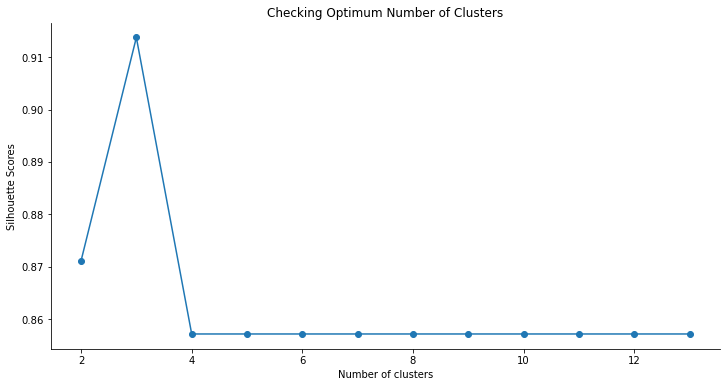

In [32]:
print(scores)
print(kval)
plot(kval, scores)

In [33]:
opt = np.argmax(scores) + 2 # Finds the optimal value
opt

3

In [34]:
phxclusters = opt

phx_clustering = phx_Mexican.drop(["Neighborhoods"], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=phxclusters, random_state=1)
kmeans.fit_transform(phx_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20]

array([0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 1, 0, 2], dtype=int32)

In [35]:
phx_merged = phx_Mexican.copy()

# add clustering labels
phx_merged["Cluster Labels"] = kmeans.labels_

In [36]:
phx_merged.rename(columns={"Neighborhoods": "Neighborhood"}, inplace=True)
phx_merged.head(5)

,Neighborhood,Mexican Restaurant,Cluster Labels
0,Arcadia (Phoenix),0.000000,0
1,Biltmore Area,0.000000,0
2,Central Avenue Corridor,0.000000,0
3,"Chinatown, Phoenix",0.018182,2
4,Desert Ridge,0.000000,0


In [37]:
phx_merged = phx_merged.join(Phoenix_venues.set_index("Neighborhood"), on="Neighborhood")

print(phx_merged.shape)
phx_merged.head()

(296, 9)


,Neighborhood,Mexican Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Arcadia (Phoenix),0.0,0,33.502560,-111.973986,Shemer Art Center & Museum,33.505025,-111.971996,Art Gallery
0,Arcadia (Phoenix),0.0,0,33.502560,-111.973986,Monsoon Driving,33.505769,-111.973916,Lake
0,Arcadia (Phoenix),0.0,0,33.502560,-111.973986,Reed's Candle Light Observatory,33.499291,-111.977236,Planetarium
1,Biltmore Area,0.0,0,33.518471,-112.025525,Arizona Biltmore Golf Course,33.521478,-112.023028,Golf Course
1,Biltmore Area,0.0,0,33.518471,-112.025525,Wrigley Mansion,33.522777,-112.026997,American Restaurant


In [38]:
phx_merged.sort_values(["Cluster Labels"], inplace=True)
phx_merged.head()


,Neighborhood,Mexican Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Arcadia (Phoenix),0.0,0,33.502560,-111.973986,Shemer Art Center & Museum,33.505025,-111.971996,Art Gallery
8,"Maryvale, Phoenix",0.0,0,33.492882,-112.174764,El Super,33.493698,-112.170507,Grocery Store
4,Desert Ridge,0.0,0,33.634140,-111.930610,Ladlow's Fine Furniture,33.631946,-111.926744,Furniture / Home Store
9,"Moon Valley, Phoenix",0.0,0,33.619229,-112.084337,Leirdac Café,33.616478,-112.081429,Food
9,"Moon Valley, Phoenix",0.0,0,33.619229,-112.084337,The bLOO Room Incubator Studio,33.623000,-112.082411,Design Studio


In [39]:
map_clusters = folium.Map(location=[latitude, longitude],zoom_start=14)

# set color scheme for the clusters


# add markers to the map
markers_colors={}
markers_colors[0] = 'red'
markers_colors[1] = 'blue'
markers_colors[2] = 'green'
for lat, lon, cluster in zip(phx_merged['Neighborhood Latitude'], phx_merged['Neighborhood Longitude'], phx_merged['Cluster Labels']):
    
    folium.CircleMarker(
        [lat, lon],
        radius=5,
       
        color =markers_colors[cluster],
        fill_color=markers_colors[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Analyzing of each cluster

In [40]:
#Cluster 0
Phxcls0=phx_merged.loc[(phx_merged['Cluster Labels'] ==0) & (phx_merged['Venue Category'] == 'Mexican Restaurant') ]

Phxcls0

,Neighborhood,Mexican Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category


In [43]:
#Cluster 1
Phxcls1=phx_merged.loc[(phx_merged['Cluster Labels'] ==1) & (phx_merged['Venue Category'] == 'Mexican Restaurant') ]
Phxcls1

,Neighborhood,Mexican Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
11,"Sacred Heart Church (Phoenix, Arizona)",0.142857,1,33.434282,-112.056118,Carolina's Mexican Food,33.431507,-112.056058,Mexican Restaurant


In [41]:
#Cluster 2

Phxcls2=phx_merged.loc[(phx_merged['Cluster Labels'] ==2) & (phx_merged['Venue Category'] == 'Mexican Restaurant') ]
Phxcls2

,Neighborhood,Mexican Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
6,F. Q. Story Neighborhood Historic District,0.018182,2,33.448250,-112.075800,Cocina 10,33.451771,-112.076588,Mexican Restaurant
13,Woodlea Historic District,0.018182,2,33.448250,-112.075800,Cocina 10,33.451771,-112.076588,Mexican Restaurant
3,"Chinatown, Phoenix",0.018182,2,33.448250,-112.075800,Cocina 10,33.451771,-112.076588,Mexican Restaurant
5,Downtown Phoenix,0.016393,2,33.447992,-112.073579,Willie's Taco Joint,33.446402,-112.069831,Mexican Restaurant


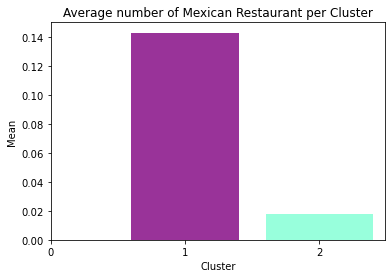

In [44]:
clusters_mean = [Phxcls0['Mexican Restaurant'].mean(),Phxcls1['Mexican Restaurant'].mean(),Phxcls2['Mexican Restaurant'].mean()]
objects = (0,1,2)
y_pos = np.arange(len(objects))
perf = clusters_mean
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','aquamarine' ])
plt.xticks(y_pos, objects)
plt.ylabel('Mean')
plt.xlabel('Cluster')
plt.title('Average number of Mexican Restaurant per Cluster')

plt.show()

Cluster 1 has most of the Mexican Restaurant followed by Cluster 2

## Result
In the map given above, Cluster 0 (Red color) has no Mexican restaurants. Therefore, this project recommends the entrepreneur to open Mexican Restaurant in these neighborhoods with little to no competition.
